In [175]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
import sys
sys.path.append('../scripts/')
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.stats import pearsonr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from epsilon_tools import *
from tools import alphabet

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1.2)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

warnings.simplefilter('ignore')

In [205]:
def pearson(dataarray1,dataarray2):
    a = np.log(dataarray1.values) 
    b = np.log(dataarray2.values)
    mask = np.isfinite(a) & np.isfinite(b)
    return pearsonr(a[mask],b[mask])

def plot_correlation(darray1,darray2):
    ind, bins = np.histogram(darray1, bins=30, range=(1e-12,1e-7));
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

    g = sns.jointplot(x=darray1,y=darray2,kind='scatter',dropna=True,
                 xlim=(1e-14,1e-5),ylim=(1e-14,1e-5), marginal_kws={'bins':logbins},)
    g.ax_joint.set_xscale('log')
    g.ax_joint.set_yscale('log')
    g.ax_joint.set_xlabel(r'$\epsilon$ (RC)')
    g.ax_joint.set_ylabel(r'$\epsilon$ (MLE Kraichnan)')

    r2, pvalue = pearson(darray1,darray2)
    g.ax_joint.annotate(rf'r$^2$ = {r2:2.2f}'+'\n'+rf'p = {pvalue:2.3f}',(0.2,0.78),xycoords='figure fraction')

    g.ax_joint.plot(darray1, darray1, color='k', lw=0.2);
    
def ruddick_fig6_kra(ds):
    f,ax = plt.subplots(2,3,figsize=(20,12))

    ds['var_y_kra1'] = np.var(ds.y_kra1, axis=1) 
    
    logbins = find_logbins(ds.var_y_kra1, nbins=30, ranges=(1e-1,1e3))
    ds.var_y_kra1.plot.hist(density=True, range=(1e-1,1e3), xscale='log', ax=ax[0,0], bins=logbins)
#     plt.hist(dataset, bins=bins, normed=True, cumulative=True, label='CDF DATA', 
#          histtype='step', alpha=0.55, color='purple')
    cdf = ax[0,0].twinx()
    ds.var_y_kra1.plot.hist(density=True, range=(1e-1,1e3), xscale='log', ax=cdf, bins=logbins, cumulative=True, histtype='step',color='k')
    cdf.set_title(None)
    
    ax[0,0].set_xlabel('Variance')
    ax[0,0].set_ylabel('Frequency')
    ax[0,0].set_title(None)
    ax[0,0].axvline(6, color='r')
    
    logbins = find_logbins(ds.mad1_kra, nbins=30, ranges=(1e-1,5e1))
    ds.mad1_kra.plot.hist(density=True, range=(1e-1,5e1), xscale='log', ax=ax[0,1], bins=logbins)
    
    cdf = ax[0,1].twinx()
    ds.mad1_kra.plot.hist(density=True, range=(1e-1,5e1), xscale='log', ax=cdf, bins=logbins, cumulative=True, histtype='step',color='k')
    cdf.set_title(None)
    ax[0,1].set_xlabel('MAD')
    ax[0,1].set_title(None)
    ax[0,1].axvline(6, color='r')

    ds.lhr1_bat.plot.hist(density=True, range=(-400,400), xscale='linear', ax=ax[0,2], bins=30)
    
    cdf = ax[0,2].twinx()
    ds.lhr1_kra.plot.hist(density=True, range=(-400,400), xscale='linear', ax=cdf, bins=30, cumulative=True, histtype='step',color='k')
    cdf.set_title(None)
    cdf.set_ylabel('CDF')
    ax[0,2].set_xlabel('LH')
    ax[0,2].set_title(None)
    ax[0,2].axvline(-200, color='r')

    ds.plot.scatter(x='var_y_kra1', y='lhr1_kra', ax=ax[1,0])
    ax[1,0].set_xscale('log')
    ax[1,0].set_xlim(1e-1,1e3)
    ax[1,0].set_ylim(-400,400)
    ax[1,0].set_xlabel('Variance')
    ax[1,0].set_ylabel('LH')
#     ax[1,0].axvline(10, color='r')
#     ax[1,0].axhline(2, color='r')
    ax[1,0].fill_between(x=[1e-1,10],y1=2,y2=1e3, alpha=0.2)
    
    ds.plot.scatter(x='mad1_kra', y='lhr1_kra', ax=ax[1,1])
    ax[1,1].set_xscale('log')
    ax[1,1].set_xlim(1e-1,1e2)
    ax[1,1].set_ylim(-400,400)
    ax[1,1].set_xlabel('MAD')
    ax[1,1].set_ylabel('LH')
#     ax[1,1].axvline(3, color='r')
#     ax[1,1].axhline(2, color='r')
    ax[1,1].fill_between(x=[5,-200],y1=10,y2=1e3, alpha=0.2)

    ds.plot.scatter(x='mad1_kra', y='var_y_kra1', ax=ax[1,2])
    ax[1,2].set_xscale('log')
    ax[1,2].set_yscale('log')
    ax[1,2].set_xlim(1e-1,1e2)
    ax[1,2].set_ylim(1e-1,1e3)
    ax[1,2].set_xlabel('MAD')
    ax[1,2].set_ylabel('Variance')
    
    ax[1,2].fill_between(x=[1e-1,3],y1=1e-1,y2=10, alpha=0.2, label='keep')
    ax[1,2].legend(loc=4)
#     alphabet(ax)

    plt.tight_layout()

    plt.savefig('../figures/ruddick_fig6_kra.pdf')
    plt.show()

### Load uncleaned data:

In [200]:
ds = xr.open_dataset('../data/test_profiles//variable_dof8.nc')
ds = mad_wrapper(ds,p)

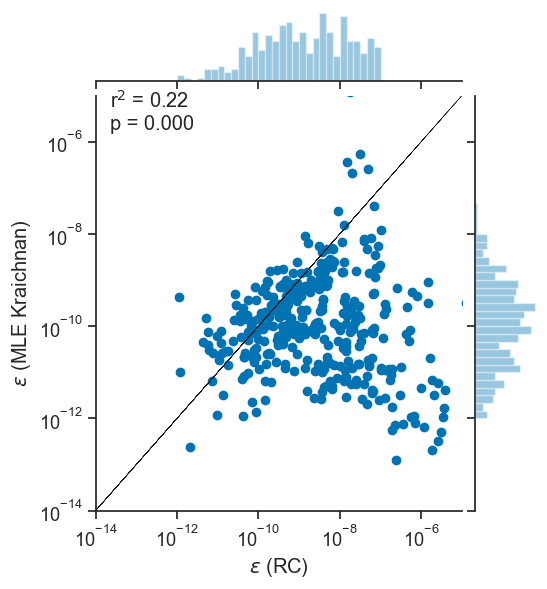

In [201]:
plot_correlation(ds.eps1_rc, ds.eps1_kra)

### Ruddick's QC plot

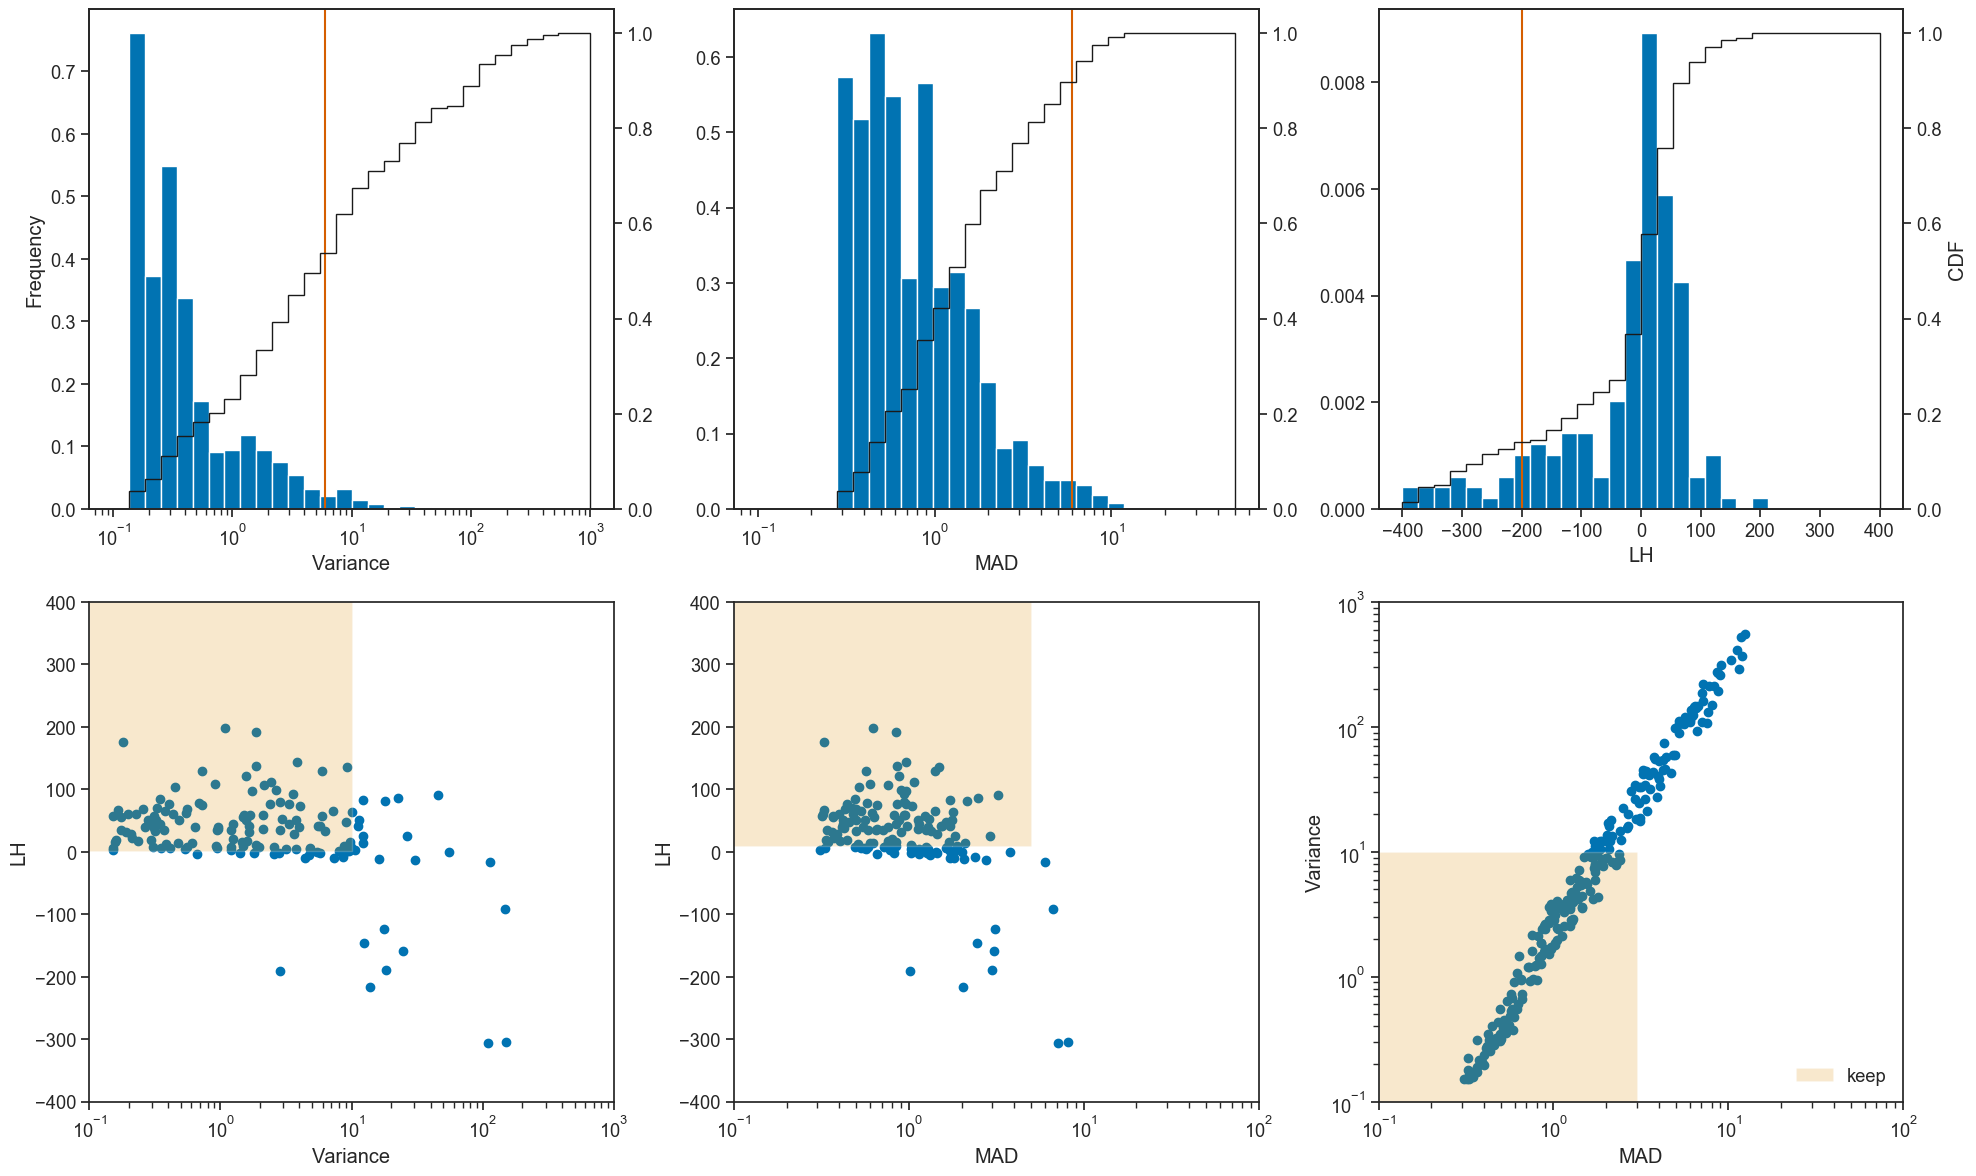

In [206]:
ruddick_fig6_kra(ds)

### Ren-Chieh's QC

1. thresholds for dtdz, chi, and kt
2. remove times of sensor malfunction
3. combine the two sensors

In [181]:
ds = threshold_for_chi(ds,p)
ds = rm_sensor_malfunction(ds,p)
ds = combine_two_sensors(ds,p)

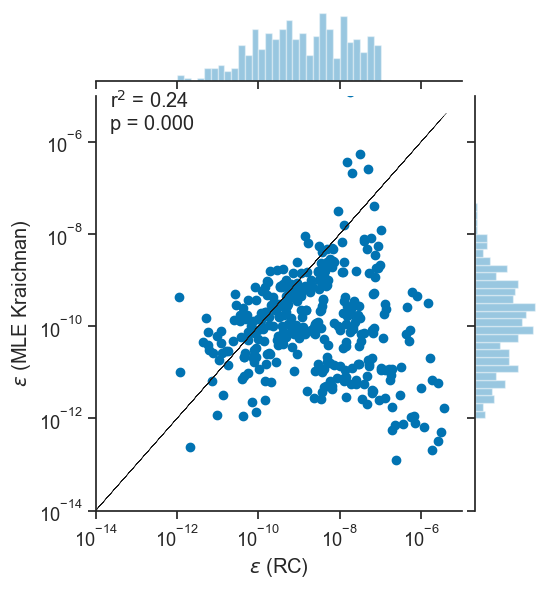

In [182]:
plot_correlation(ds.eps_rc, ds.eps1_kra)

### LR-based QC

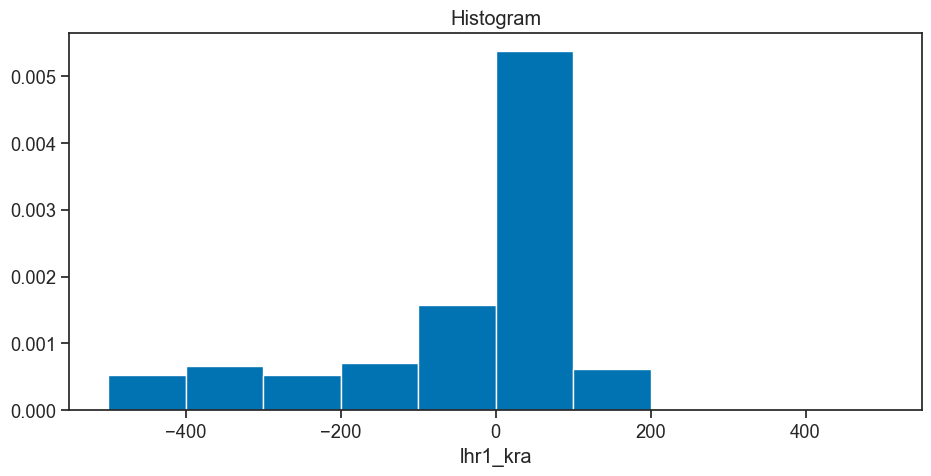

In [183]:
ds.lhr1_kra.plot.hist(density=True, range=(-500,500), xscale='linear');

In [184]:
lhrmin = -300
print(madmax)

ds['eps1_kra'] = ds['eps1_kra'].where( ds['lhr1_kra']>lhrmin)
ds['eps1_bat'] = ds['eps1_bat'].where( ds['lhr1_bat']>lhrmin)

ds['eps2_kra'] = ds['eps2_kra'].where( ds['lhr2_kra']>lhrmin)
ds['eps2_bat'] = ds['eps2_bat'].where( ds['lhr2_bat']>lhrmin)

5.656854249492381


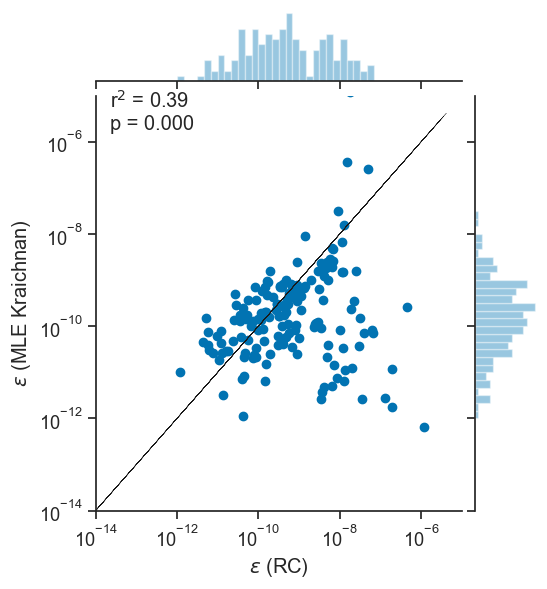

In [185]:
plot_correlation(ds.eps_rc, ds.eps1_kra)

In [186]:
print( 100*np.isfinite(ds['eps1_bat']).sum()/ ds['eps1_bat'].size )
print( 100*np.isfinite(ds['eps1_kra']).sum()/ ds['eps1_kra'].size )

<xarray.DataArray 'eps1_bat' ()>
array(45.01278772)
<xarray.DataArray 'eps1_kra' ()>
array(47.31457801)


### MAD-based QC

In [187]:
def find_logbins(array,nbins,ranges):
    _, bins = np.histogram(array, bins=nbins, range=ranges)
    return np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

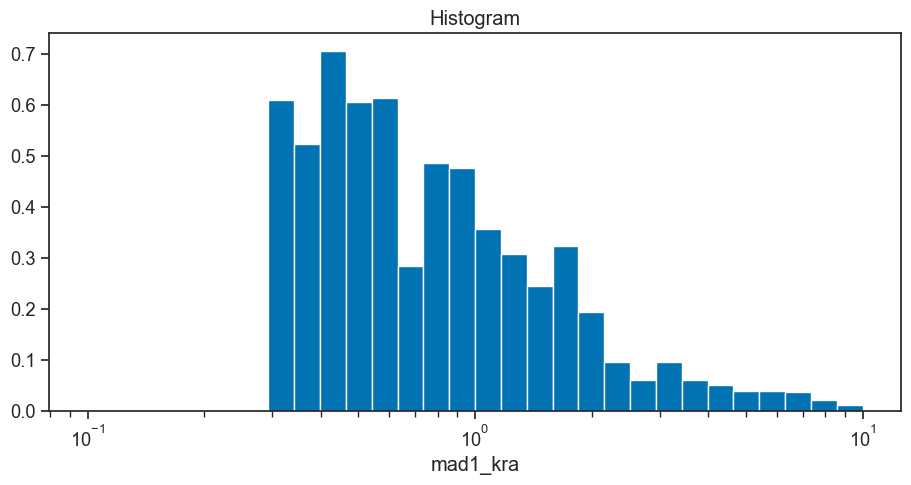

In [188]:
logbins = find_logbins(ds.mad1_kra, nbins=30, ranges=(1e-1,1e1))
ds.mad1_kra.plot.hist(density=True, range=(1e-1,1e1), xscale='log', bins=logbins);

In [189]:
dmin=4
madmax = 8*(2/dmin)**0.5
print(madmax)

ds['eps1_kra'] = ds['eps1_kra'].where( ds['mad1_kra']<madmax)
ds['eps1_bat'] = ds['eps1_bat'].where( ds['mad1_bat']<madmax)

ds['eps2_kra'] = ds['eps2_kra'].where( ds['mad2_kra']<madmax)
ds['eps2_bat'] = ds['eps2_bat'].where( ds['mad2_bat']<madmax)

5.656854249492381


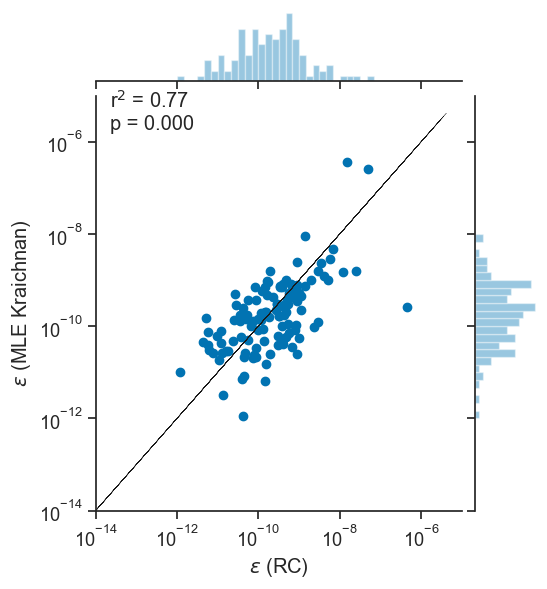

In [190]:
plot_correlation(ds.eps_rc, ds.eps1_kra)

In [191]:
print( 100*np.isfinite(ds['eps1_bat']).sum()/ ds['eps1_bat'].size )
print( 100*np.isfinite(ds['eps1_kra']).sum()/ ds['eps1_kra'].size )

<xarray.DataArray 'eps1_bat' ()>
array(35.54987212)
<xarray.DataArray 'eps1_kra' ()>
array(36.57289003)
